In [41]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import lightgbm as lgb
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import LabelEncoder
from multiprocessing import Pool
import subprocess
import matplotlib.pyplot as plt
import os
import time
from sklearn.model_selection import TimeSeriesSplit, KFold, StratifiedKFold
from sklearn.model_selection import GroupKFold
from features import get_features
from features import encode_label
from features import encode_mean_k_fold
from features import encode_frequency
from features import encode_lda

from report import report
from report import get_feature_importance
from report import submit_to_kaggle
import operator
from tqdm import tqdm
import seaborn as sns
import pprint as pp
from itertools import combinations

from tools import drop_cols
from tools import print_corr
from tools import compare_corr
from tools import dict_to_sortedlist


# def drop_cols(df, cols):
#     drop_cols = [c for c in df.columns if c in cols]
#     df.drop(drop_cols, axis=1, inplace=True)
#     return df


# def print_corr(df_corr, keyword=None):
#     sns.heatmap(
#         df_corr,
#         annot=True,
#         xticklabels=df_corr.columns.values,
#         yticklabels=df_corr.columns.values)

#     corr_dict = {}
#     for c in list(combinations(df_corr.columns, 2)):
#         corr_dict[c] = df_corr.loc[c[0], c[1]]

#     corr_list = []
#     for i, corr in enumerate(
#             sorted(
#                 corr_dict.items(), key=operator.itemgetter(1), reverse=True)):
#         if keyword:
#             if keyword in corr:
#                 corr_list.append("{} {}".format(i, corr))
#             else:
#                 pass
#         else:
#             corr_list.append("{} {}".format(i, corr))
#     pp.pprint(corr_list)
#     return corr_list


# def compare_corr(df_train, df_test):
#     df_train_corr = df_train.corr()
#     df_test_corr = df_test.corr()

#     corr_dict_train = {}
#     corr_dict_test = {}
#     corr_dict = {}
#     for c in list(combinations(df_train_corr.columns, 2)):
#         corr_dict_train[c] = df_train_corr.loc[c[0], c[1]]
#         corr_dict_test[c] = df_test_corr.loc[c[0], c[1]]
#         corr_dict[c] = abs(corr_dict_train[c] - corr_dict_test[c])

#     return corr_dict, corr_dict_train, corr_dict_test

# def dict_to_sortedlist(d):
#     l = []
#     for i, row in enumerate(
#             sorted(
#                 d.items(), key=operator.itemgetter(1), reverse=True)):
#         l.append("{} {}".format(i, row))
#     return l

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load pickle

In [2]:
%%time
df_train = pd.read_pickle("input/train_lv01.pickle")
df_test = pd.read_pickle("input/test_lv01.pickle")

train_size = df_train.shape[0]
target_col = 'totals_transactionRevenue'
df_train[target_col].fillna(0.0, inplace=True)
df_train[target_col] = df_train[target_col].astype(float)


# Drop cols nunique < 2
del_cols = ['totals_bounces', 'totals_newVisits', 'visitId']
df_train = drop_cols(df_train, del_cols)
df_test = drop_cols(df_test, del_cols)

CPU times: user 7.19 s, sys: 1.68 s, total: 8.87 s
Wall time: 7.62 s


#### Corr df_train

In [ ]:
_ = print_corr(df_train.corr())

In [ ]:
_ = print_corr(df_train[df_train[target_col] > 0].corr())

In [ ]:
_ = print_corr(df_train[df_train[target_col] == 0].corr())

#### Corr df_test

In [ ]:
_ = print_corr(df_test.corr())

### DEV

#### trafficSource_medium

,trafficSource_medium,totals_hits
0,(none),4.928614
1,(not set),4.400000
2,affiliate,3.405475
3,cpc,6.499961
4,cpm,6.667199
5,organic,4.928795
6,referral,3.944231


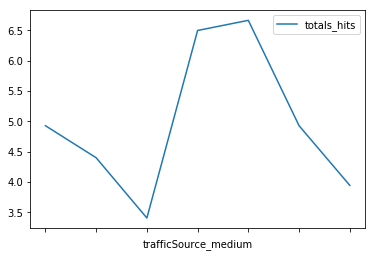

In [3]:
df_g = df_train.groupby(['trafficSource_medium'])['totals_hits'].mean().reset_index()
df_g.plot(x='trafficSource_medium')
df_g

,trafficSource_medium,totals_hits
0,(none),4.071541
1,(not set),1.764706
2,affiliate,3.477108
3,cpc,2.534803
4,cpm,5.960329
5,organic,4.505722
6,referral,4.423155


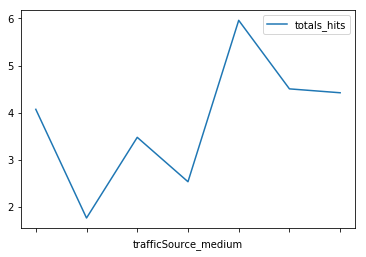

In [4]:
df_g = df_test.groupby(['trafficSource_medium'])['totals_hits'].mean().reset_index()
df_g.plot(x='trafficSource_medium')
df_g

#### *_hits_per_day

In [ ]:
df_g = df_train.groupby(['day'])['totals_hits'].sum().reset_index()
df_g.plot()
df_g

In [ ]:
df_g = df_test.groupby(['day'])['totals_hits'].sum().reset_index()
df_g.plot()
df_g

#### Freq

In [ ]:
corr_cols = [c for c in df_train_X if '_Fre' in c]
corr_cols

In [ ]:
df_test['channelGrouping_Frequency'].plot()


#### Compare corr between train and test

In [ ]:
corr_cols = [c for c in df_train_X if '_Fre' in c]
corr_dict, corr_train, corr_test = compare_corr(df_train[corr_cols], df_test[corr_cols])
pp.pprint(corr_dict)
pp.pprint(corr_train)
pp.pprint(corr_test)

In [ ]:
dict_to_sortedlist(corr_dict)

In [ ]:
df_train['trafficSource_adwordsClickInfo.isVideoAd'].value_counts()

### Feature Engineering

In [5]:
%%time
df_train, fea_cols = get_features(df_train)
df_test, fea_cols = get_features(df_test)
df_train[target_col] = np.log1p(df_train[target_col])

'fea_date_time'  16447.63 ms
'fea_format'  103.12 ms
'fea_device'  2195.12 ms
'fea_totals'  1930.79 ms
'fea_geo_network'  392.59 ms
'fea_traffic_source'  2568.23 ms
'fea_date_time'  14172.53 ms
'fea_format'  93.61 ms
'fea_device'  1987.77 ms
'fea_totals'  1709.75 ms
'fea_geo_network'  341.45 ms
'fea_traffic_source'  2256.90 ms
CPU times: user 1min 5s, sys: 7.02 s, total: 1min 12s
Wall time: 44.2 s


In [ ]:
fea_cols

#### corr df_train and df_test

In [ ]:
_ = print_corr(df_train.corr())

In [ ]:
_ = print_corr(df_test.corr())

#### ttest between df_train and df_test

In [ ]:
# from scipy.stats import ttest_ind
# c = 'browser_category'
# print(c, ttest_ind(df_train[c], df_test[c], equal_var=False))

# for c in fea_cols:
#     print(c, ttest_ind(df_train[c], df_test[c], equal_var=False))

### Encodings

In [6]:
not_used_cols = [
    "date",
    "fullVisitorId",
    "sessionId",
    "visitId",
    'trafficSource_campaignCode',
    target_col,
    #     "visitNumber",
    #     "visitStartTime",
    #     'trafficSource_referralPath',
]

categorical_feature = df_train.select_dtypes(include='object').columns
categorical_feature = [
    c for c in categorical_feature if c not in not_used_cols
]
df_train[categorical_feature].fillna('NA_NULL', inplace=True)
df_test[categorical_feature].fillna('NA_NULL', inplace=True)

len(categorical_feature)

/Users/hyundai/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


28

#### Label Encoding

In [7]:
df_train, df_test = encode_label(df_train, df_test, categorical_feature)

['channelGrouping', 'device_browser', 'device_deviceCategory', 'device_isMobile', 'device_operatingSystem', 'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region', 'geoNetwork_subContinent', 'trafficSource_adContent', 'trafficSource_adwordsClickInfo.adNetworkType', 'trafficSource_adwordsClickInfo.gclId', 'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_adwordsClickInfo.page', 'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign', 'trafficSource_isTrueDirect', 'trafficSource_keyword', 'trafficSource_medium', 'trafficSource_referralPath', 'trafficSource_source', 'browser_category', 'browser_operatingSystem', 'source_country', 'campaign_medium']


100%|██████████| 28/28 [00:42<00:00,  1.15s/it]

'encode_label'  45530.40 ms


#### Freq Encoding

In [8]:
df_train, df_test = encode_frequency(df_train, df_test, categorical_feature)

100%|██████████| 28/28 [00:26<00:00,  1.04it/s]

(903653, 87) (804684, 86)
'encode_frequency'  27017.84 ms


#### Mean Encoding

In [9]:
df_train, df_test = encode_mean_k_fold(df_train, df_test, categorical_feature, target_col)

100%|██████████| 28/28 [01:28<00:00,  3.49s/it]

(903653, 115) (804684, 114)
Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitNumber',
       'visitStartTime', 'device_browser', 'device_deviceCategory',
       'device_isMobile', 'device_operatingSystem',
       ...
       'mean_k_fold_trafficSource_campaign',
       'mean_k_fold_trafficSource_isTrueDirect',
       'mean_k_fold_trafficSource_keyword', 'mean_k_fold_trafficSource_medium',
       'mean_k_fold_trafficSource_referralPath',
       'mean_k_fold_trafficSource_source', 'mean_k_fold_browser_category',
       'mean_k_fold_browser_operatingSystem', 'mean_k_fold_source_country',
       'mean_k_fold_campaign_medium'],
      dtype='object', length=115)
'encode_mean_k_fold'  88880.80 ms


#### LDA (target_col) : 망함

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# y_categorized = np.digitize(df_train[target_col], bins=np.arange(2,24,2))
# clf = LinearDiscriminantAnalysis(n_components=10)
# clf.fit(df_train[categorical_feature], y_categorized)

In [ ]:
# df_train_lda = pd.DataFrame(clf.transform(df_train[categorical_feature]))
# df_test_lda = pd.DataFrame(clf.transform(df_test[categorical_feature]))

# col_map={i:'lda_{}'.format(i) for i in range(10)}
# df_train_lda.rename(columns=col_map, inplace=True)
# df_test.rename(columns=col_map, inplace=True)

# df_train = pd.concat([df_train, df_train_lda], axis=1)
# df_test = pd.concat([df_test, df_test_lda], axis=1)                

#### LDA (totals_hits) : good

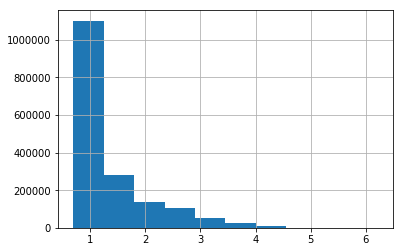

In [44]:
y_col = 'totals_hits'
merged_y = pd.concat([df_train[y_col], df_test[y_col]])
merged_y.hist()
y_categorized = np.digitize(merged_y, bins=np.arange(0,6,1))

In [39]:
df_train, df_test = encode_lda(df_train, df_test, categorical_feature, y_categorized, lda_name=y_col)

lda_totals_hits_0to9
(903653, 135) (804684, 134)
'encode_lda'  9400.47 ms


#### LDA (hits / pageviews) : 망함

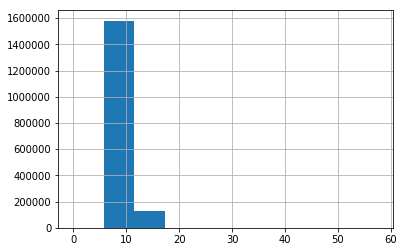

In [79]:
y_col = 'hits_pageviews_rate'
merged_y = pd.concat([
    df_train['totals_hits'] / df_train['totals_pageviews'],
    df_test['totals_hits'] / df_test['totals_pageviews']
])
merged_y[np.isinf(merged_y)] = 0
merged_y = merged_y * 10
merged_y.hist()

In [80]:
bins = np.arange(10,25,1)
bins = np.insert(bins, 0, 0)
y_categorized = np.digitize(merged_y, bins=bins)
np.unique(y_categorized, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 array([    239, 1516036,  108655,   57641,    3977,    7589,   11486,
            590,     290,      61,      11,    1408,      12,      11,
            120,     211]))

In [81]:
df_train, df_test = encode_lda(df_train, df_test, categorical_feature, y_categorized, lda_name=y_col)

lda_hits_pageviews_rate_0to9


/Users/hyundai/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


(903653, 145) (804684, 139)
'encode_lda'  13677.04 ms


### Split X and y, Remove not_used_cols

In [82]:
df_train_y = df_train[target_col].astype(float)

df_train_idx = df_train[['fullVisitorId', target_col]]
df_train_X = drop_cols(df_train.copy(), not_used_cols)

df_test_idx = df_test[['fullVisitorId']]
df_test_X = drop_cols(df_test.copy(), not_used_cols)

### Training 531

In [83]:
feature_name = list(df_train_X.columns)
print(feature_name)
prediction_train = np.zeros(df_train_X.shape[0])
prediction = np.zeros(df_test_X.shape[0])

['channelGrouping', 'visitNumber', 'visitStartTime', 'device_browser', 'device_deviceCategory', 'device_isMobile', 'device_operatingSystem', 'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region', 'geoNetwork_subContinent', 'totals_hits', 'totals_pageviews', 'trafficSource_adContent', 'trafficSource_adwordsClickInfo.adNetworkType', 'trafficSource_adwordsClickInfo.gclId', 'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_adwordsClickInfo.page', 'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign', 'trafficSource_isTrueDirect', 'trafficSource_keyword', 'trafficSource_medium', 'trafficSource_referralPath', 'trafficSource_source', 'month', 'day', 'hour', 'weekday', 'month_unique_user_count', 'weekday_unique_user_count', 'hour_unique_user_count', 'user_hour_mean', 'user_hour_max', 'user_hour_min', 'browser_category', 'browser_operatingSystem', 'mean_hour_per_browser_operatingSystem', 'source_co

In [84]:
submit_file_path = ''


def modeling(fold_col, X_train, X_valid, y_train, y_valid):
    print('X_train:', X_train.shape, 'X_valid:', X_valid.shape, 'Rate:',
          X_valid.shape[0] / X_train.shape[0])
    if X_valid.shape[0] / X_train.shape[0] > 1.0:
        print('No Execution')
        return

    train = lgb.Dataset(
        X_train.values,
        label=y_train.values,
        feature_name=feature_name,
        #         categorical_feature=categorical_feature
    )

    valid = lgb.Dataset(
        X_valid.values,
        label=y_valid.values,
        feature_name=feature_name,
        #         categorical_feature=categorical_feature
    )

    #     params = {
    #         "objective": "regression",
    #         "metric": "rmse",
    #         "max_depth": 8,
    #         "min_child_samples": 20,
    #         "reg_alpha": 1,
    #         "reg_lambda": 1,
    #         "num_leaves": 257,
    #         "learning_rate": 0.01,
    #         "subsample": 0.8,
    #         "colsample_bytree": 0.8,
    #         "subsample_freq ": 5,
    #     }
    #     params = {
    #     "objective": "regression",
    #     "metric": "rmse",
    #     "num_leaves": 30,
    #     "min_child_samples": 100,
    #     "learning_rate": 0.1,
    #     "bagging_fraction": 0.7,
    #     "feature_fraction": 0.5,
    #     "bagging_frequency": 5,
    #     "bagging_seed": 2018,
    #     "verbosity": -1
    # }

    # param = {
    #     "objective": "regression",
    #     "metric": "rmse",
    #     "max_depth": 8,
    #     "min_child_samples": 21,
    #     "reg_alpha": 1,
    #     "reg_lambda": 1,
    #     "num_leaves": 257,
    #     "learning_rate": 0.01,
    #     "subsample": 0.82,
    #     "colsample_bytree": 0.84,
    #     "verbosity": -1
    # }

    params = {
        "objective": "regression",
        "metric": "rmse",
        "num_leaves": 30,
        "min_child_samples": 100,
        "learning_rate": 0.1,
        "bagging_fraction": 0.7,
        "feature_fraction": 0.5,
        "bagging_frequency": 5,
        "bagging_seed": 1989,
        "verbosity": -1,
        'seed': 1989
    }

    evals_result = {}
    train_params = {
        'params': params,
        'train_set': train,
        'valid_sets': [train, valid],
        'valid_names': ['train', 'valid'],
        'early_stopping_rounds': 300,  #50
        'num_boost_round': 10000,  #500
        'verbose_eval': 25,
        'feval': None,
        'evals_result': evals_result,
        #     'categorical_feature': 'auto',
    }

    model = lgb.train(**train_params)

    global prediction_train, prediction
    print('predict train set')
    pred_train = model.predict(
        df_train_X.values, num_iteration=model.best_iteration)
    prediction_train += pred_train
    df_fold_train = df_train_idx.copy()
    df_fold_train[fold_col] = pred_train

    print('predict test set')
    pred = model.predict(df_test_X.values, num_iteration=model.best_iteration)
    prediction += pred
    df_fold_test = df_test_idx.copy()
    df_fold_test[fold_col] = pred

    # report
    global submit_file_path
    submit_file_path = ''
    msg = [fold_col, str(df_train_X.columns), str(train_params)]
    submit_file_path = report(df_fold_train, df_fold_test, pred_train, pred,
                              msg, model)
    print(submit_file_path)

    return model

In [85]:
cond = df_train['date'] <= 20170531
X_train, X_valid = df_train_X[cond], df_train_X[~cond]
y_train, y_valid = df_train_y[cond], df_train_y[~cond]

model = modeling('once', X_train, X_valid, y_train, y_valid)

X_train: (765707, 141) X_valid: (137946, 141) Rate: 0.18015507237102443
Training until validation scores don't improve for 300 rounds.
[25]	train's rmse: 1.63148	valid's rmse: 1.74104
[50]	train's rmse: 1.58466	valid's rmse: 1.70151
[75]	train's rmse: 1.56259	valid's rmse: 1.69333
[100]	train's rmse: 1.54504	valid's rmse: 1.69044
[125]	train's rmse: 1.52836	valid's rmse: 1.68798
[150]	train's rmse: 1.51355	valid's rmse: 1.68627
[175]	train's rmse: 1.50234	valid's rmse: 1.68528
[200]	train's rmse: 1.49009	valid's rmse: 1.68498
[225]	train's rmse: 1.47951	valid's rmse: 1.68431
[250]	train's rmse: 1.47014	valid's rmse: 1.68426
[275]	train's rmse: 1.46064	valid's rmse: 1.68386
[300]	train's rmse: 1.45035	valid's rmse: 1.68366
[325]	train's rmse: 1.442	valid's rmse: 1.68406
[350]	train's rmse: 1.4343	valid's rmse: 1.68448
[375]	train's rmse: 1.42495	valid's rmse: 1.68451
[400]	train's rmse: 1.41697	valid's rmse: 1.68425
[425]	train's rmse: 1.40819	valid's rmse: 1.68476
[450]	train's rmse: 1

raw_train: results/2018-09-29T142344__T1.453_V1.683_R1.158_K/reg_train_2018-09-29T142344.csv
raw_test: results/2018-09-29T142344__T1.453_V1.683_R1.158_K/reg_test_2018-09-29T142344.csv
submit: results/2018-09-29T142344__T1.453_V1.683_R1.158_K/aiden_2018-09-29T142344.csv.tar.gz
cp -f *.ipynb results/2018-09-29T142344__T1.453_V1.683_R1.158_K
    
results/2018-09-29T142344__T1.453_V1.683_R1.158_K/aiden_2018-09-29T142344.csv.tar.gz


### Submit

In [86]:
print(submit_file_path)
msg = """label / freq / mean / lda hits / lda hit-page rate encode, add fea, remove high corr fea, 531"""
submit_to_kaggle(submit_file_path, msg)

results/2018-09-29T142344__T1.453_V1.683_R1.158_K/aiden_2018-09-29T142344.csv.tar.gz
kaggle competitions submit -c ga-customer-revenue-prediction -f results/2018-09-29T142344__T1.453_V1.683_R1.158_K/aiden_2018-09-29T142344.csv.tar.gz -m "label / freq / mean / lda hits encode, add fea, remove high corr fea, 531"
    


### ETC

In [ ]:
dict_to_sortedlist(corr_dict)

In [ ]:
df_corr = df_train_X[df_train_y > 0].corr()

In [ ]:
df_info = df_corr[(df_corr > 0.8) & (df_corr != 1.0)]


def _print(row, c):
    x = row[c]
    if not np.isnan(x):
        print(c, ':', row.name, x)


#         print(row.name)

for c in df_info.columns:
    df_info.apply(lambda row: _print(row, c), axis=1)

In [ ]:
import matplotlib.pyplot as plt

plt.matshow(df_corr)

In [ ]:
import seaborn as sns
sns.heatmap(df_corr, 
            xticklabels=df_corr.columns.values,
            yticklabels=df_corr.columns.values)

In [ ]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);

In [ ]:
plot_corr(df_train_X)

In [ ]:
df_train[target_col].hist()

In [ ]:
corr_cols = [c for c in df_train_X if '_Fre' in c]
corr_cols

In [ ]:
df_train_X['channelGrouping_Frequency'].value_counts()

In [ ]:
df_test['channelGrouping_Frequency'].value_counts()

In [ ]:
corr_cols = [c for c in df_train_X if 'mean_k_fold_' in c]
corr_cols

In [ ]:
df_train_X['mean_k_fold_channelGrouping'].value_counts()

In [ ]:
df_test['mean_k_fold_channelGrouping'].value_counts()